# Model Explainability with SageMaker Clarify

Explain dog classifier's predictions for sample images, using feature importance with super pixels.

The notebook is based on this demo
[explainability_image_classification.ipynb](https://github.com/aws/amazon-sagemaker-examples/blob/main/sagemaker-clarify/computer_vision/image_classification/explainability_image_classification.ipynb), which shows how to use SageMaker Clarify with Computer Vision models.

In order to run this notebook, you firstly need to train the dog breed classifier and deploy the endpoint with the `ENDPOINT_NAME`:

In [14]:
ENDPOINT_NAME = "dog-breed-classifier"

## Set up the default bucket and SageMaker session

In [2]:
import boto3
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()

region = boto3.Session().region_name

s3_client = boto3.client("s3")

sess = sagemaker.Session()

bucket = sess.default_bucket()

## Upload test images

I select the same sample images I used to test the deployed endpoint.

In [10]:
from pathlib import Path

test_data_prefix = Path("datasets/dogImages/test")

sample_files = [
    test_data_prefix / "046.Cavalier_king_charles_spaniel/Cavalier_king_charles_spaniel_03294.jpg",
    test_data_prefix / "101.Maltese/Maltese_06716.jpg",
    test_data_prefix / "071.German_shepherd_dog/German_shepherd_dog_04912.jpg",
]

Copy the selected images from the `test/` folder in S3 to a new folder created specifcally for a SageMaker Clarify job.

In [9]:
clarify_samples_prefix = Path("datasets/sample-images-for-sagemaker-clarify")

In [ ]:
clarify_samples_prefix = Path("datasets/sample-images-for-sagemaker-clarify")

for sample_file in sample_files:
    copy_source = {
        'Bucket': bucket,
        'Key': str(sample_file)
    }
    destination_key = str(clarify_samples_prefix / sample_file.name)
    print(f"Copying {sample_file} to {destination_key}")

    s3_client.copy_object(
        Bucket=bucket,
        CopySource=copy_source,
        Key=destination_key
    )

## Get the labels

In [12]:
import re

labels = [
    re.sub(r"^\d{3}\.", "", class_path.name)
    for class_path in sorted(list(Path("../dogImages/test").iterdir()))
]

## Set up the Clarify configs

Below I setup some config objects required for the SageMaker Clarify job:
* explainability_data_config: Config object related to configurations of the input and output dataset.
* model_config: Config object related to the endpoint.
* predictions_config: Config object to extract a predicted label from the model output.
* image_config: Config object for image data type
   - model_type: Specifies the type of a Computer Vision model (IMAGE_CLASSIFICATION | OBJECT_DETECTION)
   - num_segments: Clarify uses SKLearn's [SLIC](https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.slic) method for image segmentation to generate features/superpixels. num_segments specifies approximate number of segments to be generated.
   - segment_compactness: Balances color proximity and space proximity. Higher values give more weight to space proximity, making superpixel shapes more square/cubic. It's recommended to explore possible values on a log scale, e.g., 0.01, 0.1, 1, 10, 100, before refining around a chosen value.
* shap_config: Config object for kernel SHAP parameters
   - num_samples: total number of feature coalitions to be tested by Kernel SHAP.
 
By default, when you provide the ModelConfig with a model name, it creates a *shadow* endpoint, which is terminated automatically after the Clarify job finishes. 
However, because my model uses some custom script for pre processing (in the `inference.py` file) it didn't work. I didn't find a better way than deploying and terminating the endpoint manually.

In [ ]:
from sagemaker import clarify
model_name = "pytorch-training-2025-04-16-13-06-21-152"

s3_data_input_path = "s3://{}/{}/".format(bucket, clarify_samples_prefix)
clarify_output_prefix = f"{clarify_samples_prefix}/cv_analysis_result"
analysis_result_path = "s3://{}/{}".format(bucket, clarify_output_prefix)
explainability_data_config = clarify.DataConfig(
    s3_data_input_path=s3_data_input_path,
    s3_output_path=analysis_result_path,
    dataset_type="application/x-image",
)


model_config = clarify.ModelConfig(
    endpoint_name=ENDPOINT_NAME, content_type="image/jpeg"
)

predictions_config = clarify.ModelPredictedLabelConfig(label_headers=labels)

image_config = clarify.ImageConfig(
    model_type="IMAGE_CLASSIFICATION", num_segments=20, segment_compactness=5
)

shap_config = clarify.SHAPConfig(num_samples=500, image_config=image_config)

## SageMaker Clarify Processor

Details of the machine running the Clarify job:

In [26]:
clarify_processor = clarify.SageMakerClarifyProcessor(
    role=role, instance_count=1, instance_type="ml.m5.large", sagemaker_session=sess
)

[04/23/25 18:23:09] INFO     Ignoring unnecessary instance type: None.                            ]8;id=419882;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=543536;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py#530\530]8;;\

In [27]:
clarify_processor.run_explainability(
    data_config=explainability_data_config,
    model_config=model_config,
    explainability_config=shap_config,
    model_scores=predictions_config,
)

[04/23/25 18:23:10] INFO     Analysis Config: {'dataset_type': 'application/x-image', 'predictor':  ]8;id=277016;file:///opt/conda/lib/python3.12/site-packages/sagemaker/clarify.py\clarify.py]8;;\:]8;id=874283;file:///opt/conda/lib/python3.12/site-packages/sagemaker/clarify.py#1987\1987]8;;\
                             {'endpoint_name': 'dog-breed-classifier', 'content_type':                             
                             'image/jpeg', 'label_headers': ['Affenpinscher', 'Afghan_hound',                      
                             'Airedale_terrier', 'Akita', 'Alaskan_malamute',                                      
                             'American_eskimo_dog', 'American_foxhound',                                           
                             'American_staffordshire_terrier', 'American_water_spaniel',                           
                             'Anatolian_shepherd_dog', 'Australian_cattle_dog',                                    
                             'Australian_shepherd', 'Australian_terrier', 'Basenji',                               
                             'Basset_hound', 'Beagle', 'Bearded_collie', 'Beauceron',                              
                             'Bedlington_terrier', 'Belgian_malinois', 'Belgian_sheepdog',                         
                             'Belgian_tervuren', 'Bernese_mountain_dog', 'Bichon_frise',                           
                             'Black_and_tan_coonhound', 'Black_russian_terrier', 'Bloodhound',                     
                             'Bluetick_coonhound', 'Border_collie', 'Border_terrier', 'Borzoi',                    
                             'Boston_terrier', 'Bouvier_des_flandres', 'Boxer', 'Boykin_spaniel',                  
                             'Briard', 'Brittany', 'Brussels_griffon', 'Bull_terrier', 'Bulldog',                  
                             'Bullmastiff', 'Cairn_terrier', 'Canaan_dog', 'Cane_corso',                           
                             'Cardigan_welsh_corgi', 'Cavalier_king_charles_spaniel',                              
                             'Chesapeake_bay_retriever', 'Chihuahua', 'Chinese_crested',                           
                             'Chinese_shar-pei', 'Chow_chow', 'Clumber_spaniel', 'Cocker_spaniel',                 
                             'Collie', 'Curly-coated_retriever', 'Dachshund', 'Dalmatian',                         
                             'Dandie_dinmont_terrier', 'Doberman_pinscher', 'Dogue_de_bordeaux',                   
                             'English_cocker_spaniel', 'English_setter',                                           
                             'English_springer_spaniel', 'English_toy_spaniel',                                    
                             'Entlebucher_mountain_dog', 'Field_spaniel', 'Finnish_spitz',                         
                             'Flat-coated_retriever', 'French_bulldog', 'German_pinscher',                         
                             'German_shepherd_dog', 'German_shorthaired_pointer',                                  
                             'German_wirehaired_pointer', 'Giant_schnauzer',                                       
                             'Glen_of_imaal_terrier', 'Golden_retriever', 'Gordon_setter',                         
                             'Great_dane', 'Great_pyrenees', 'Greater_swiss_mountain_dog',                         
                             'Greyhound', 'Havanese', 'Ibizan_hound', 'Icelandic_sheepdog',                        
                             'Irish_red_and_white_setter', 'Irish_setter', 'Irish_terrier',                        
                             'Irish_water_spaniel', 'Irish_wolfhound', 'Italian_greyhound',                        
                             'Japanese_chin', 'Keeshond', 'Kerry_blue_terrier', 'Komondor',            

                    INFO     Creating processing-job with name                                      ]8;id=717073;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=923132;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#1575\1575]8;;\
                             Clarify-Explainability-2025-04-23-18-23-10-827                                        

.......................sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
We are not in a supported iso region, /bin/sh exiting gracefully with no changes.
INFO:sagemaker-clarify-processing:Starting SageMaker Clarify Processing job
INFO:analyzer.data_loading.data_loader_util:Analysis config path: /opt/ml/processing/input/config/analysis_config.json
INFO:analyzer.data_loading.data_loader_util:Analysis result path: /opt/ml/processing/output
INFO:analyzer.data_loading.data_loader_util:This host is algo-1.
INFO:analyzer.data_loading.data_loader_util:This host is the leader.
INFO:analyzer.data_loading.data_loader_util:Number of hosts in the cluster is 1.
INFO:sagemaker-clarify-processing:Running Python based analyzer for images.
INFO:analyzer.data_loading.data_loader_factory:Dataset uri: /opt/ml/processing/input/data
INFO:analyzer.data_loading.dat

## Reading Results
Let's download all the result images along with the PDF report.

In [14]:
import os

clarify_output_objects = s3_client.list_objects(Bucket=bucket, Prefix=clarify_output_prefix)
result_images = []

download_results_folder = Path("./clarify_results")
download_results_folder.mkdir(exist_ok=True)

for file_obj in clarify_output_objects["Contents"]:
    file_name = os.path.basename(file_obj["Key"])
    destination_file_name = download_results_folder / file_name
    if os.path.splitext(file_name)[1] == ".jpeg":
        result_images.append(file_name)

    print(f"Downloading s3://{bucket}/{file_obj['Key']}")
    s3_client.download_file(bucket, file_obj["Key"], destination_file_name)

Let's visualize and understand the results. The result images shows the segmented image and the heatmap.

* **Segments**: Highlights the image segments.
* **Shades of Blue**: Represents positive Shapley values indicating that the corresponding feature increases the overall confidence score.
* **Shades of Red**: Represents negative Shapley values indicating that the corresponding feature decreases the overall confidence score.

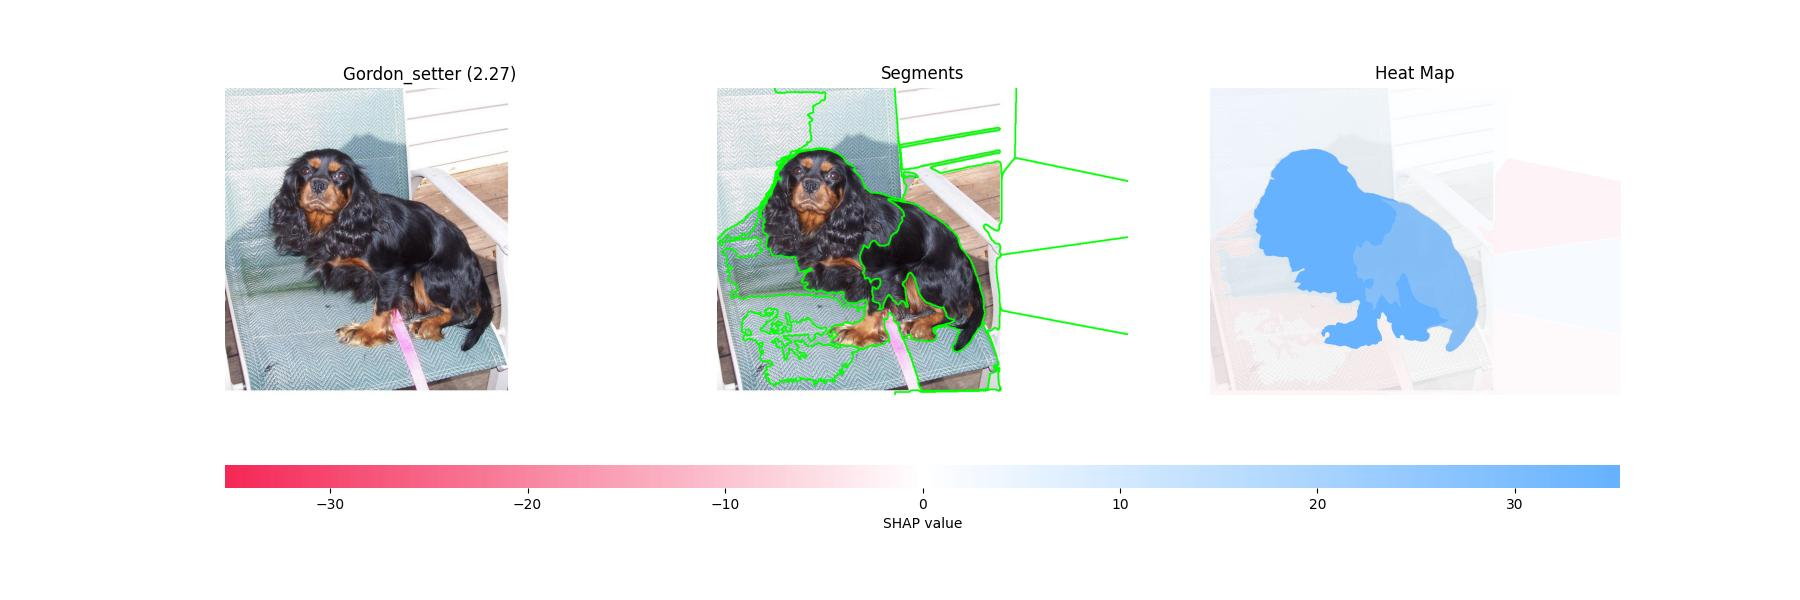

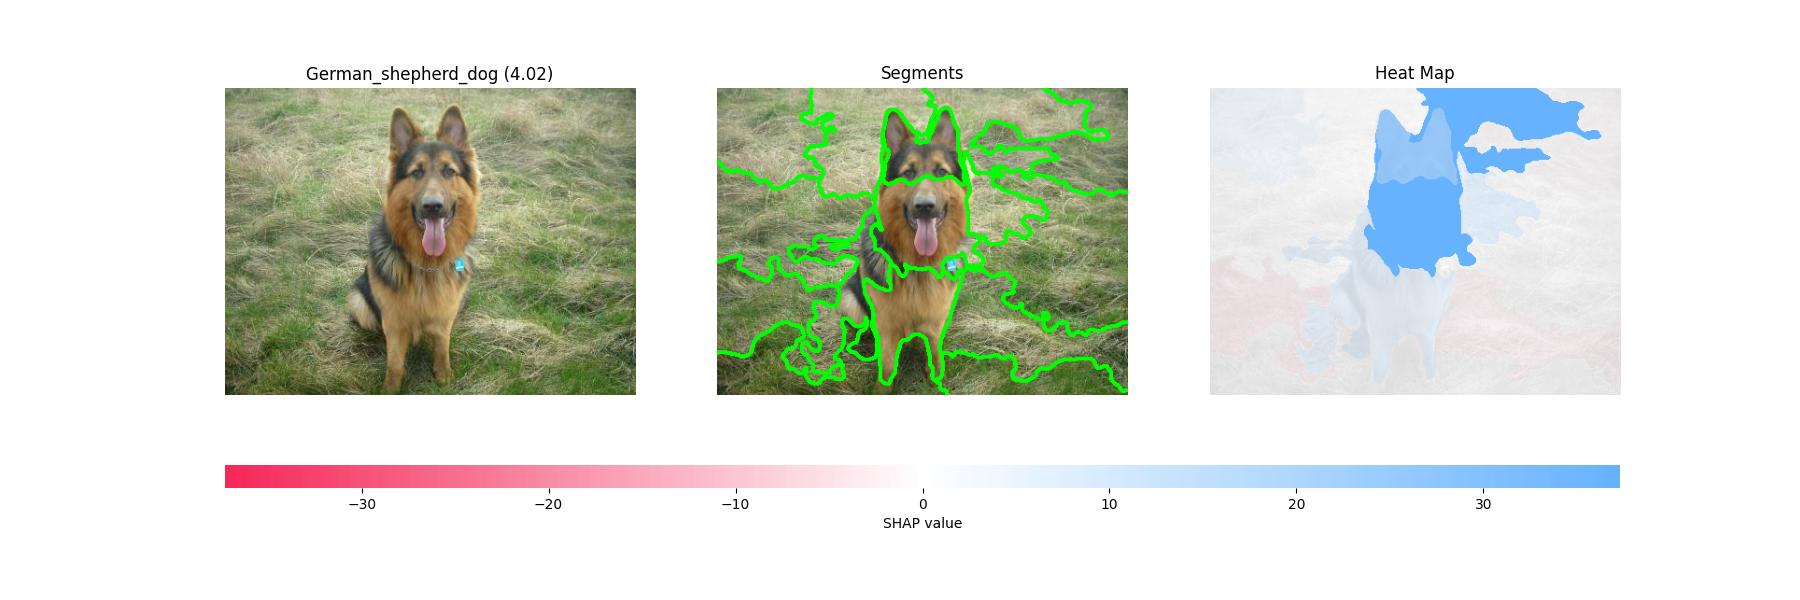

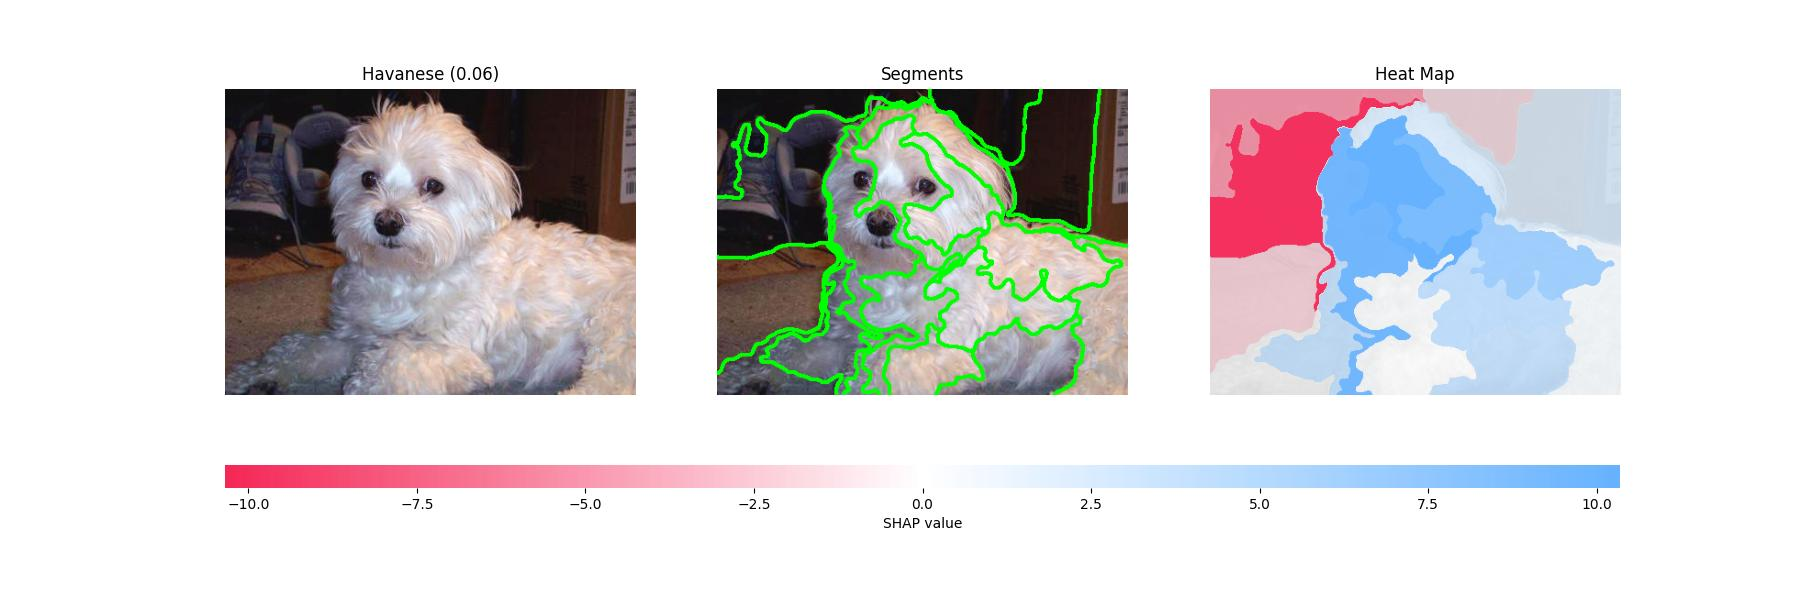

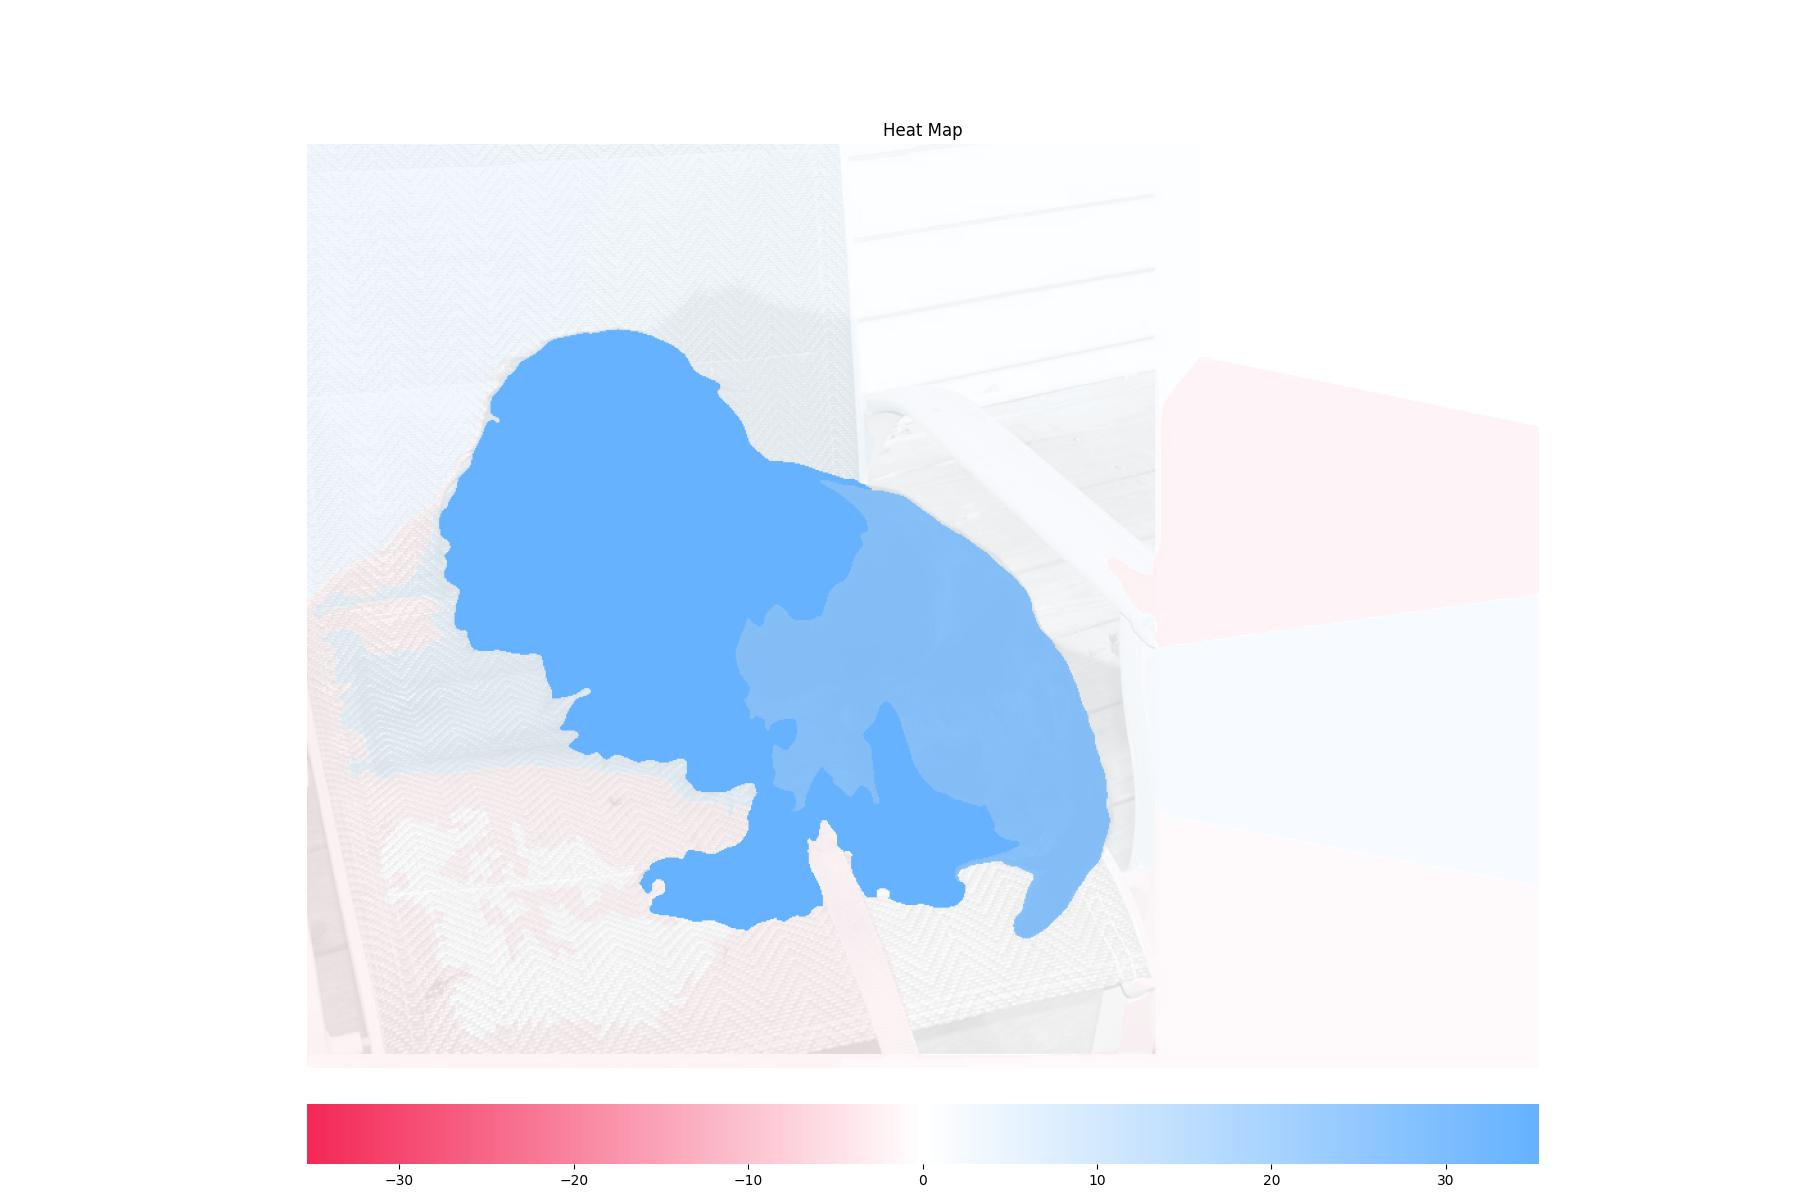

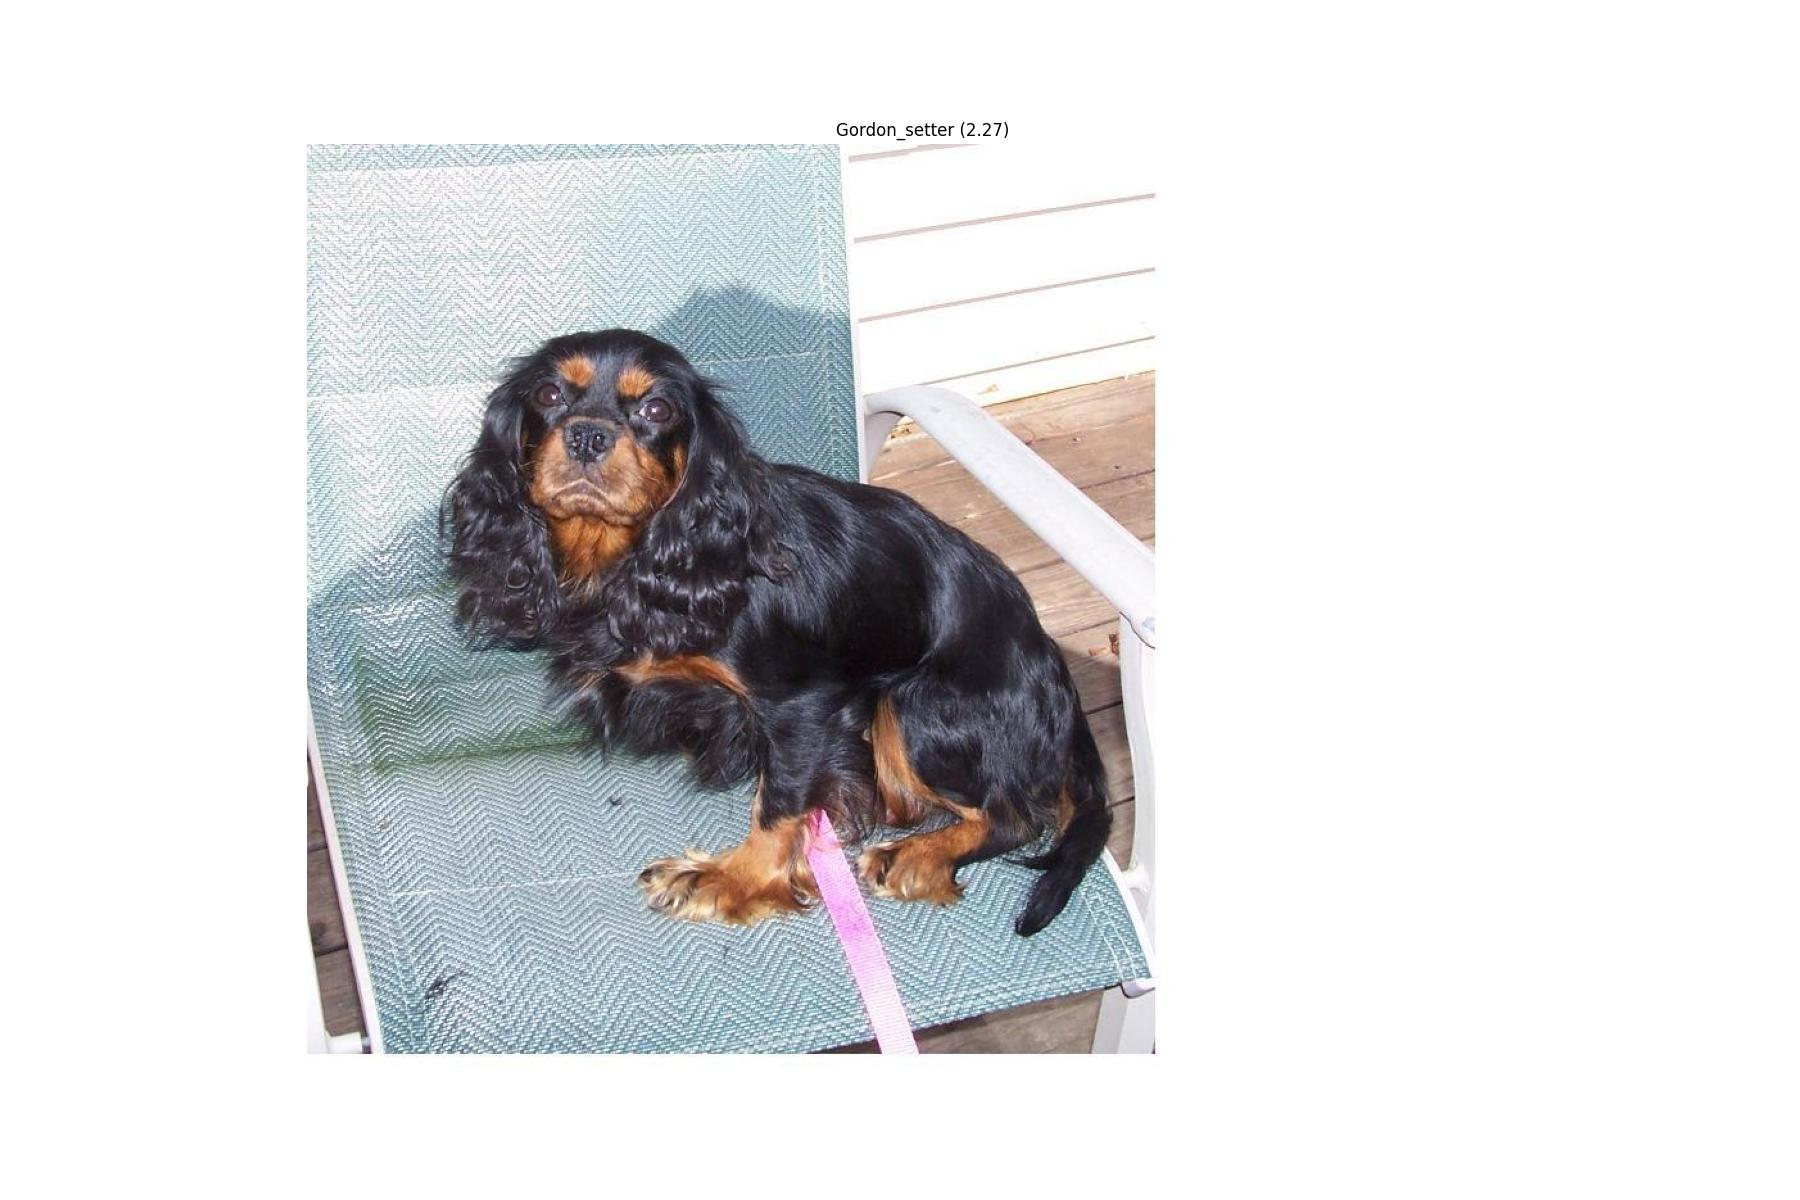

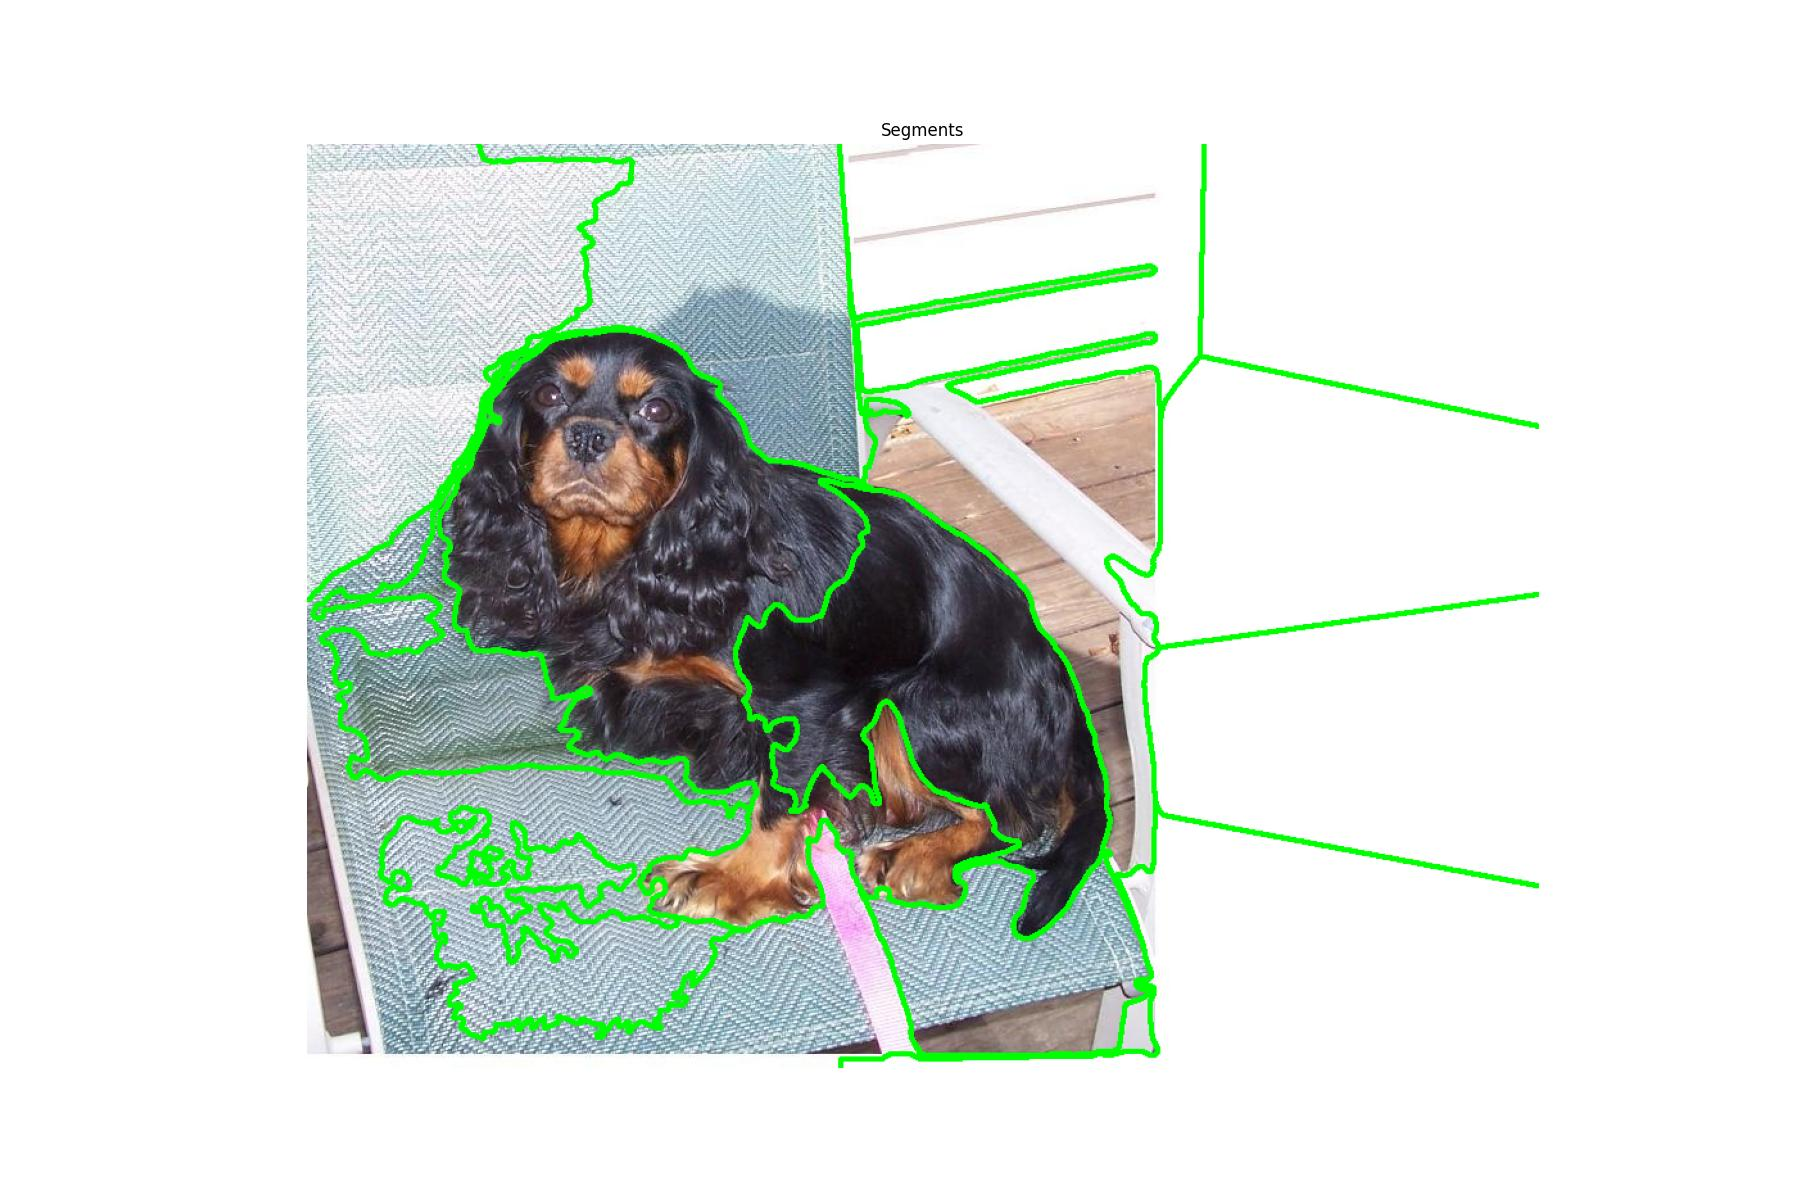

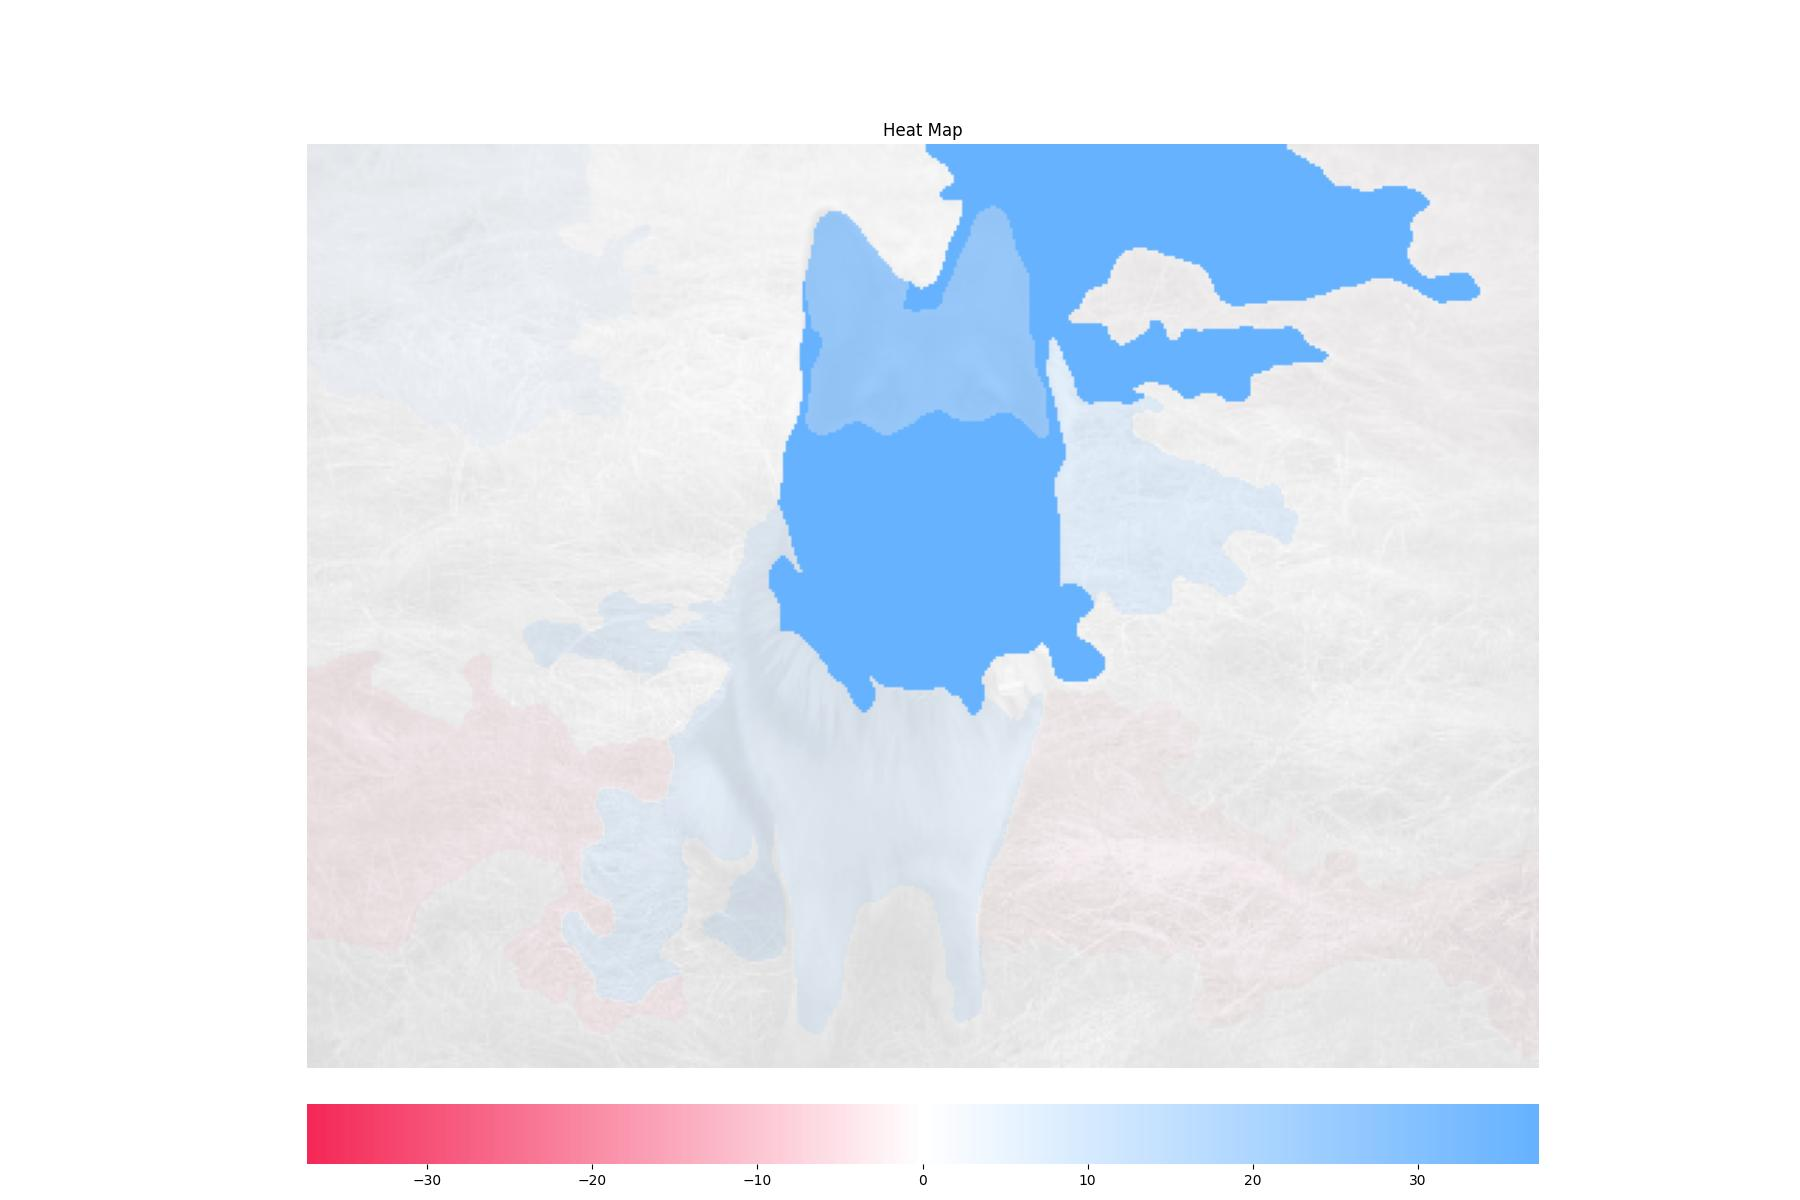

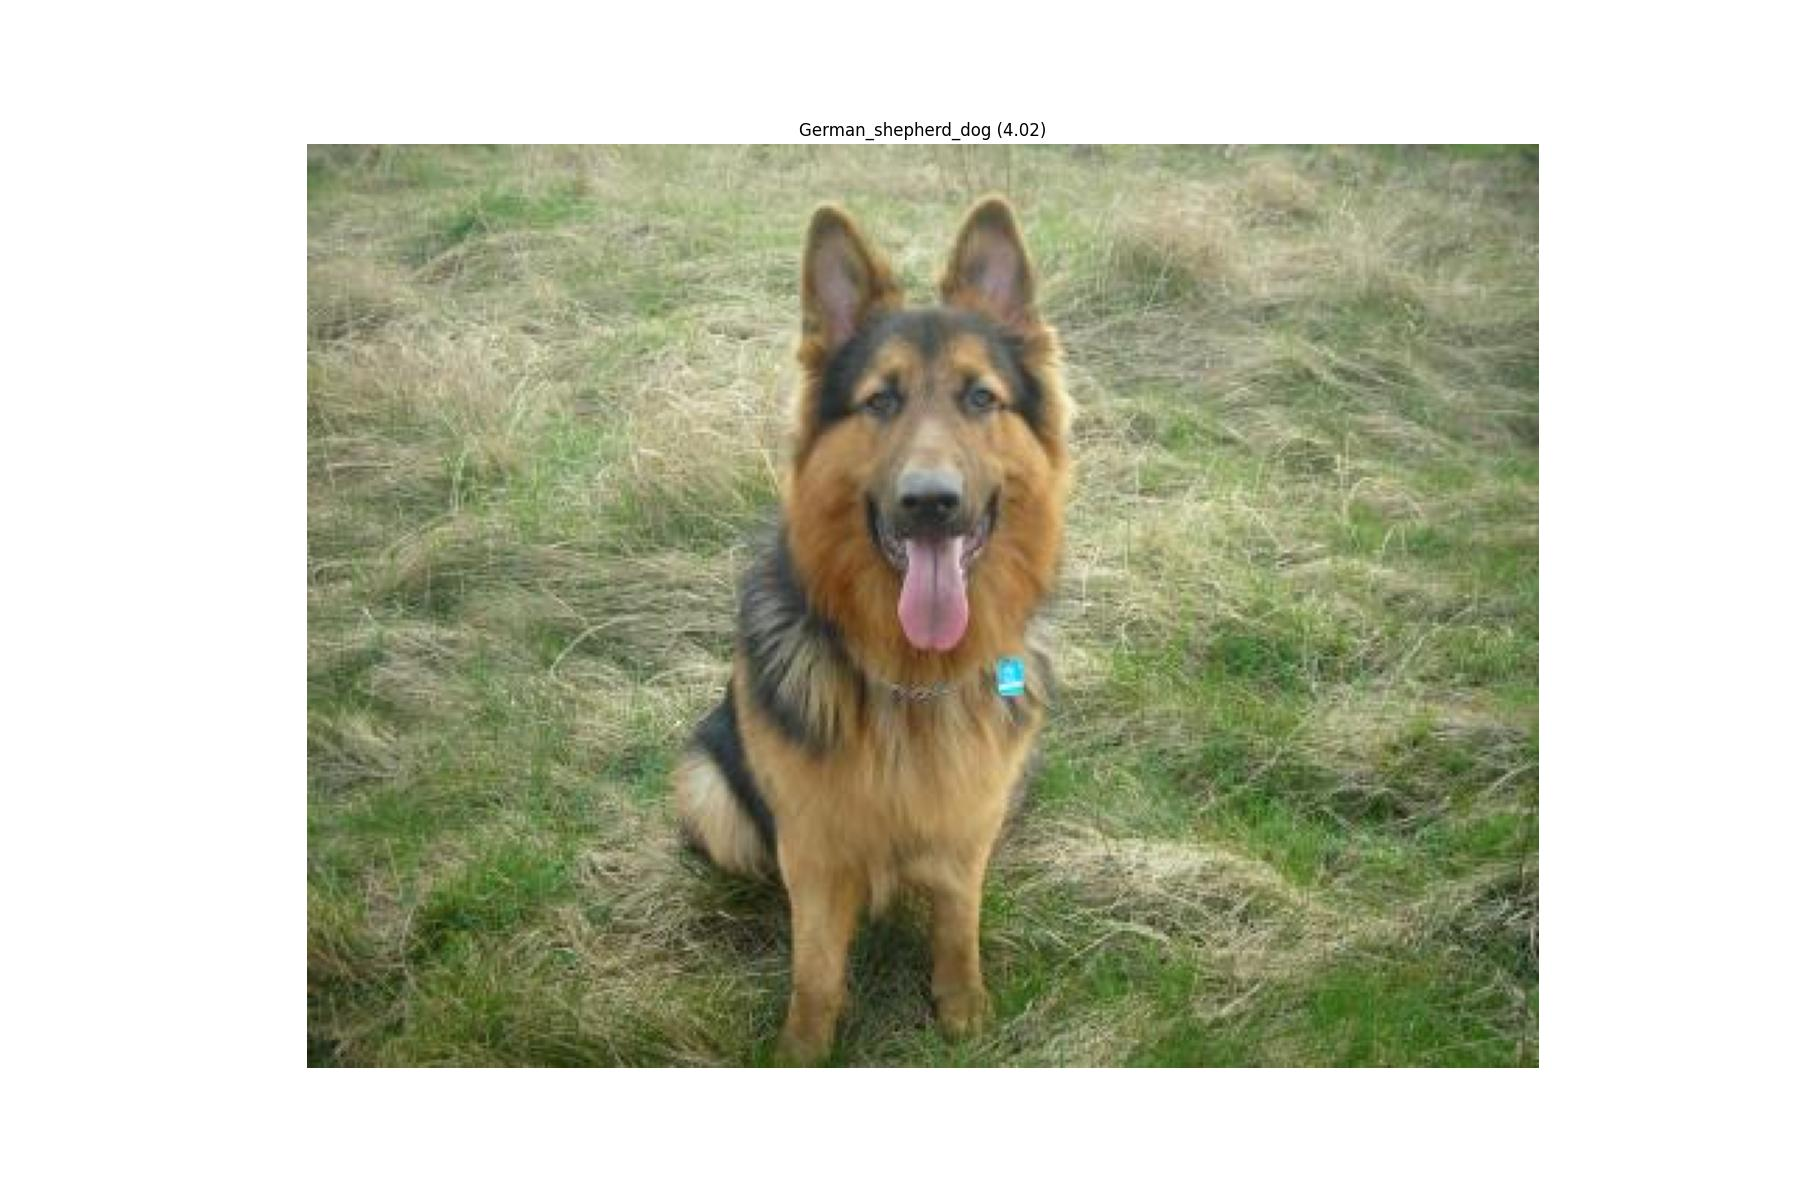

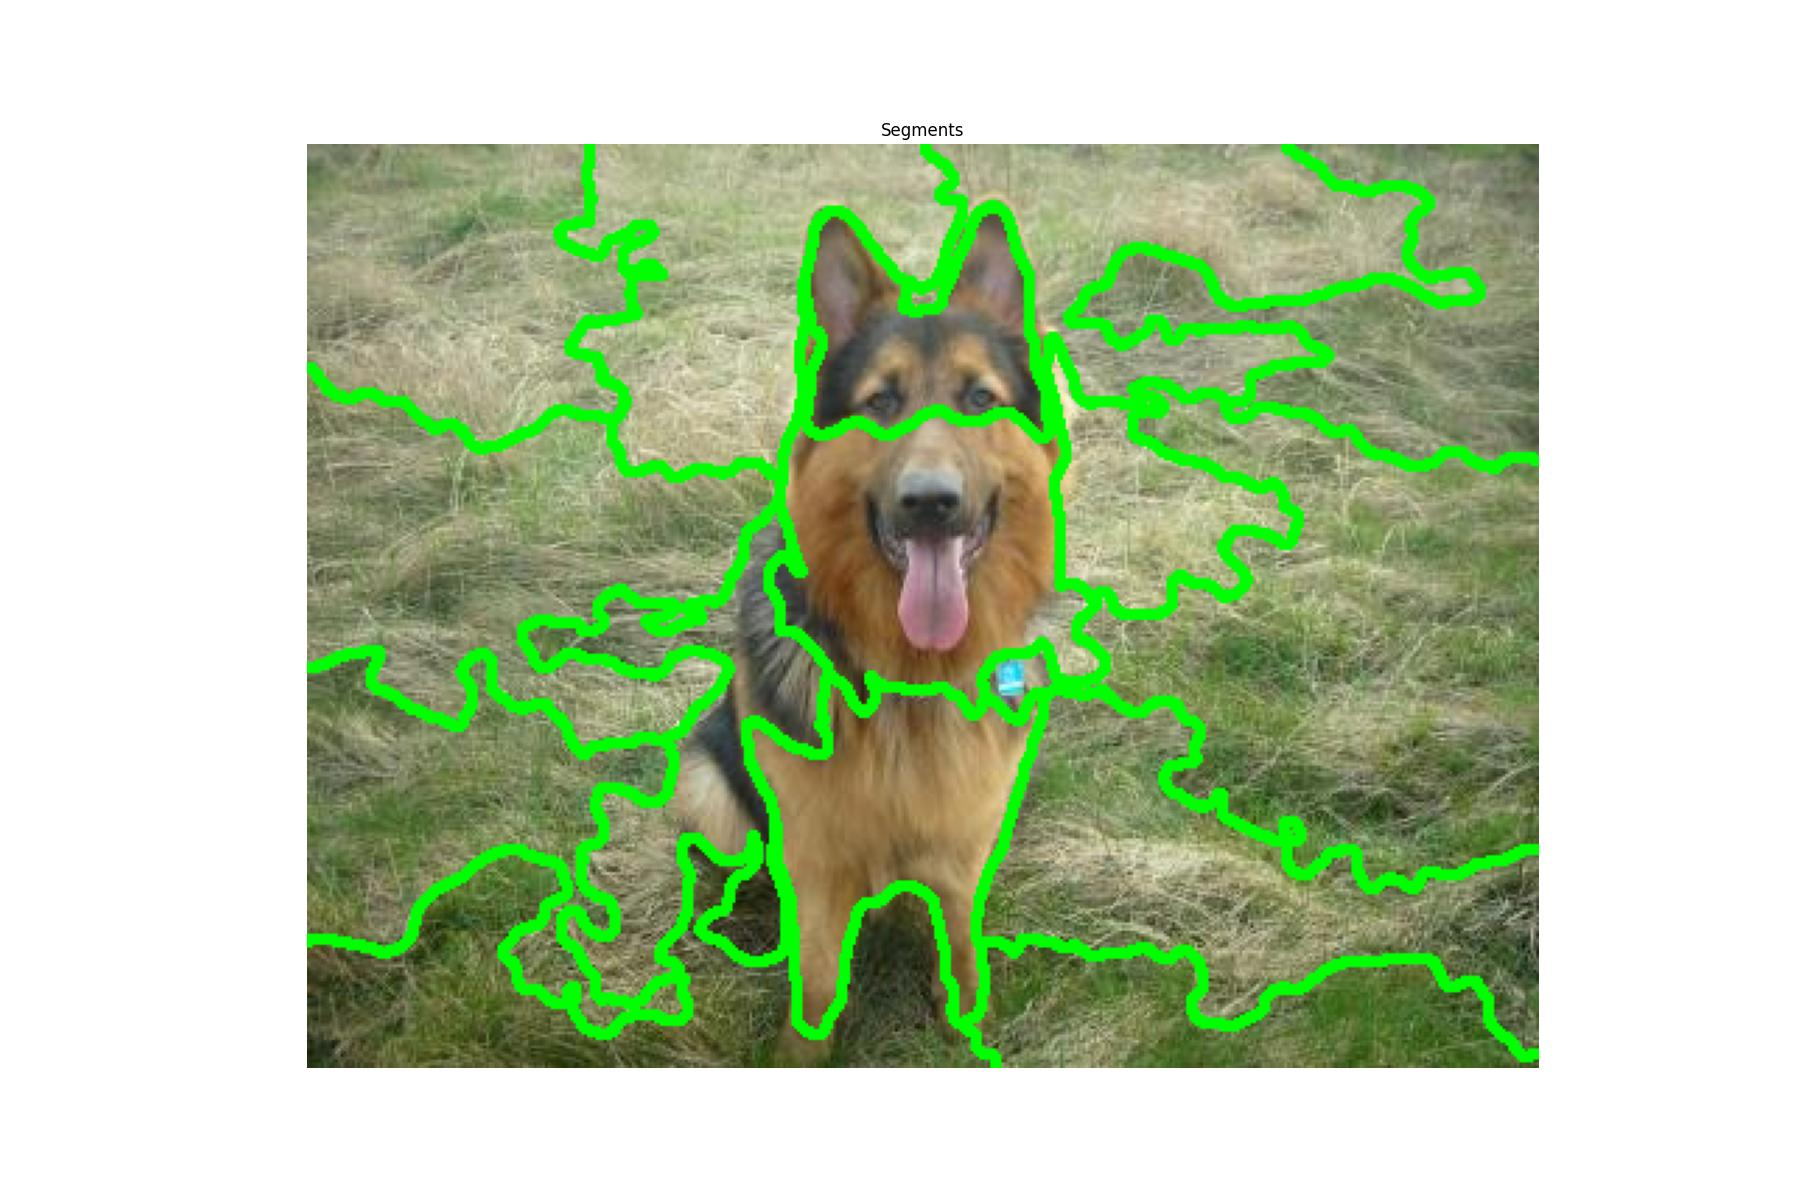

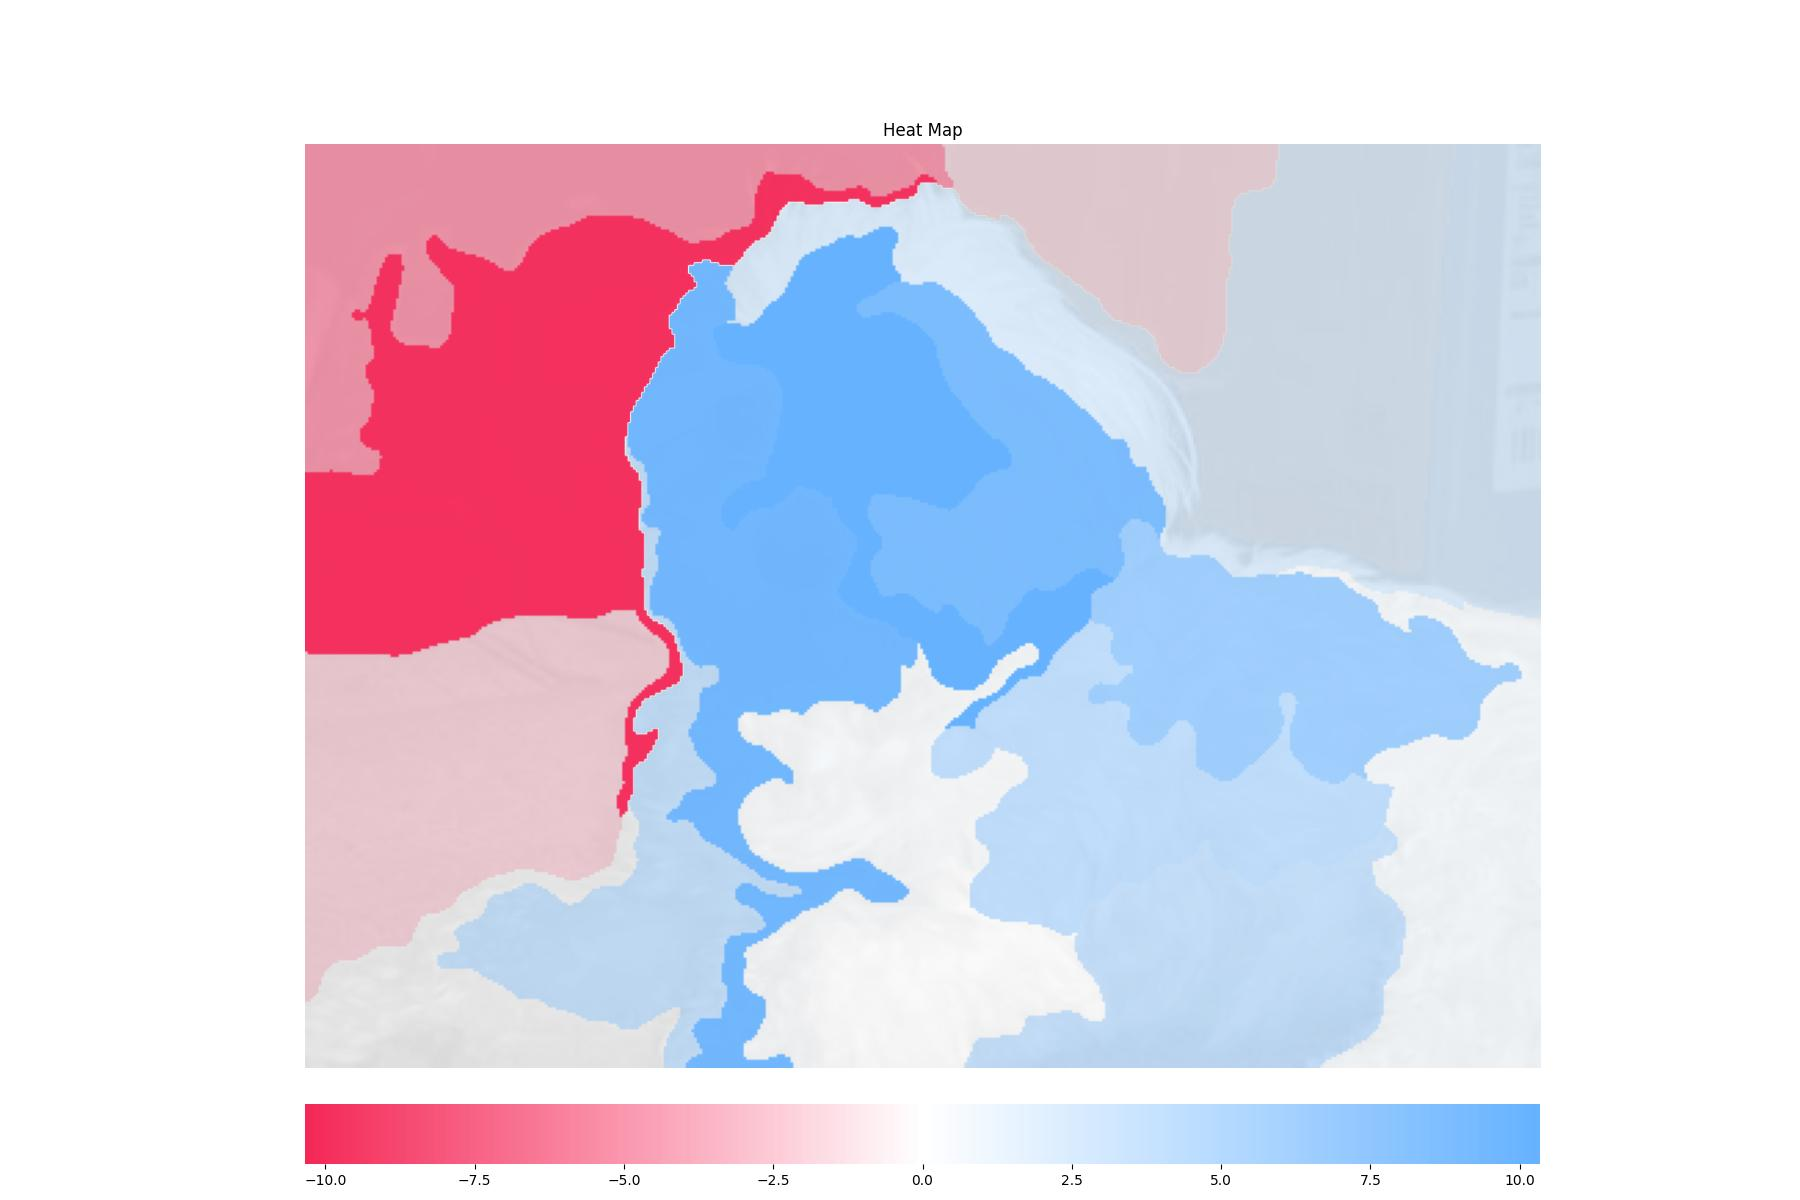

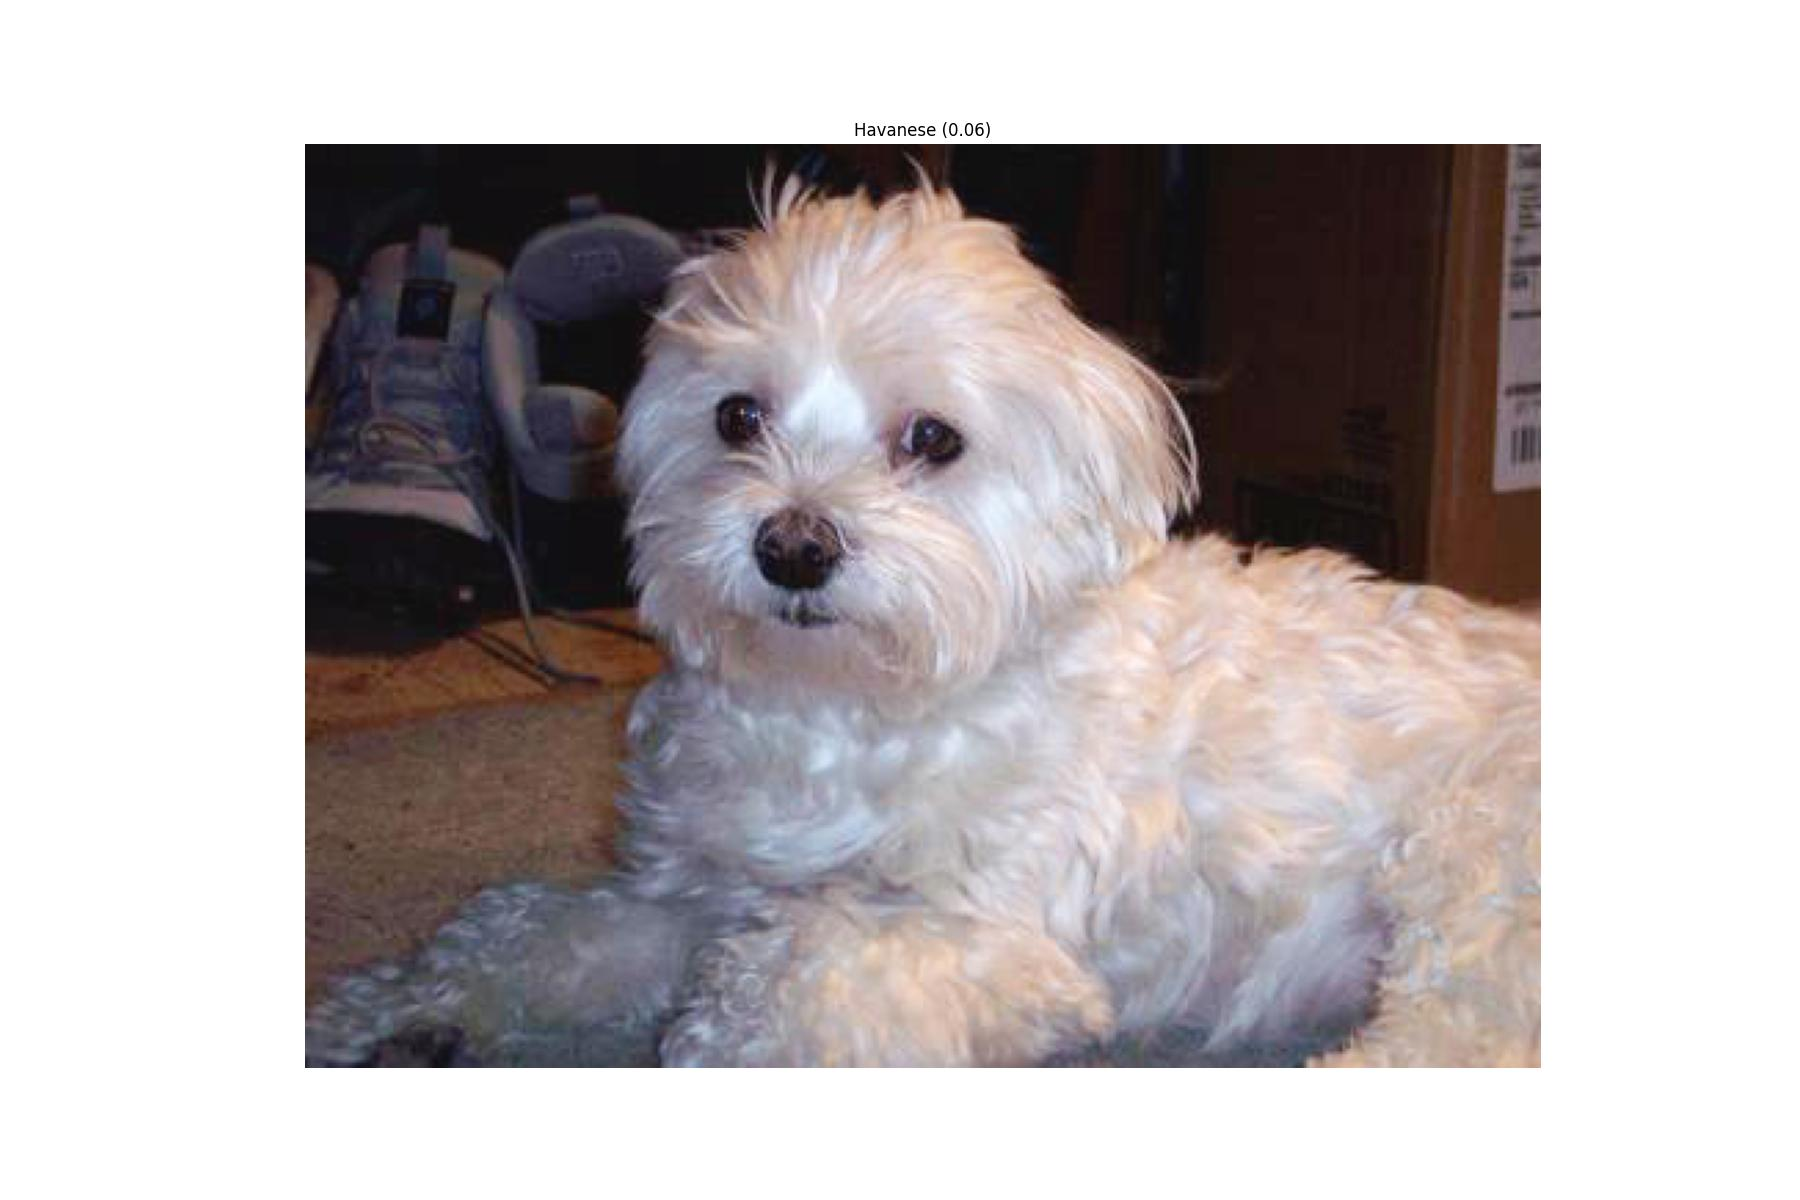

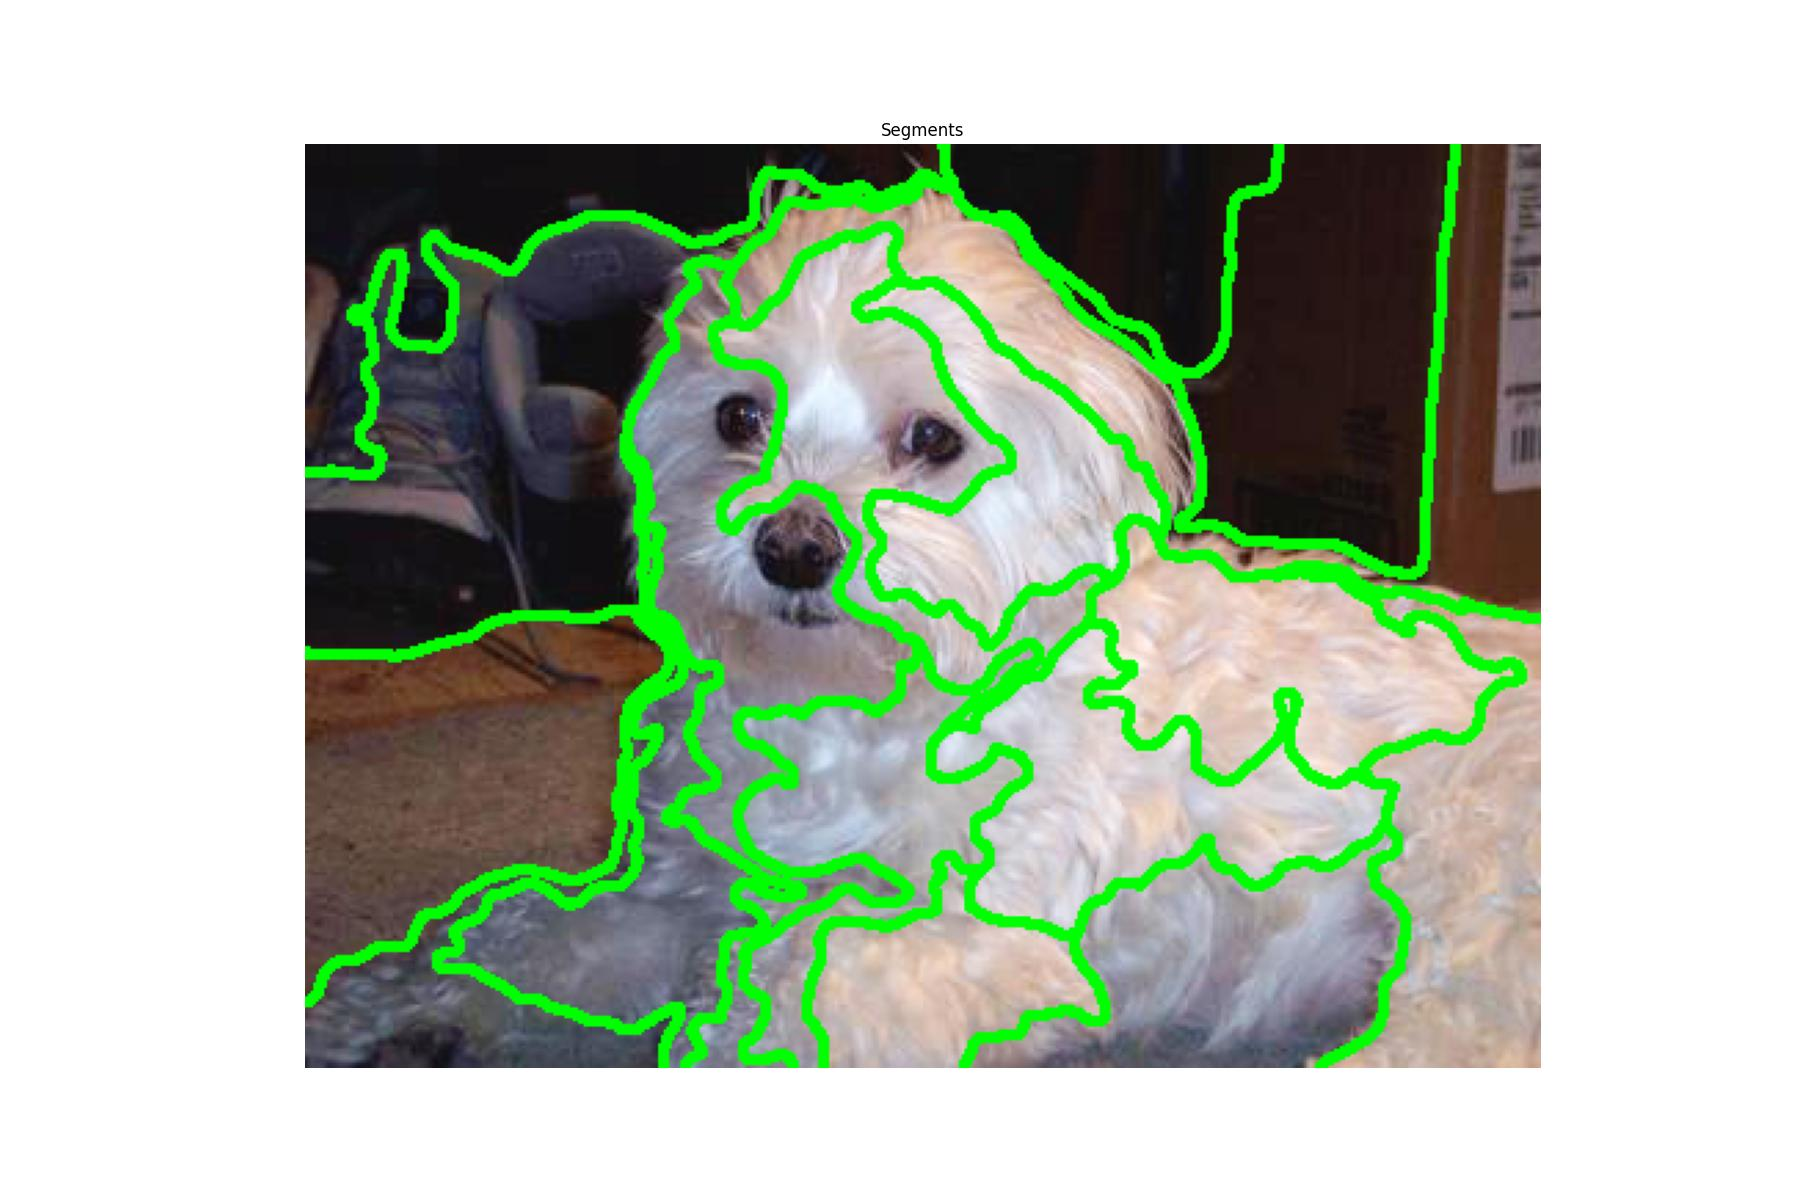

In [34]:
from IPython.display import Image

for img in result_images:
    display(Image(img))